In [1]:
# from google.colab import files
# uploaded = files.upload()

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import re
import pickle
import numpy as np
import string


file_path = 'Amazon0302.txt'


df = pd.read_csv(file_path, sep='\t', skiprows=4, header=None, names=['Start_Node', 'End_Node'], nrows=500) # Remove nrows before submitting to run on all data

G = nx.DiGraph()


for index, row in df.iterrows():
    G.add_edge(row['Start_Node'], row['End_Node'])


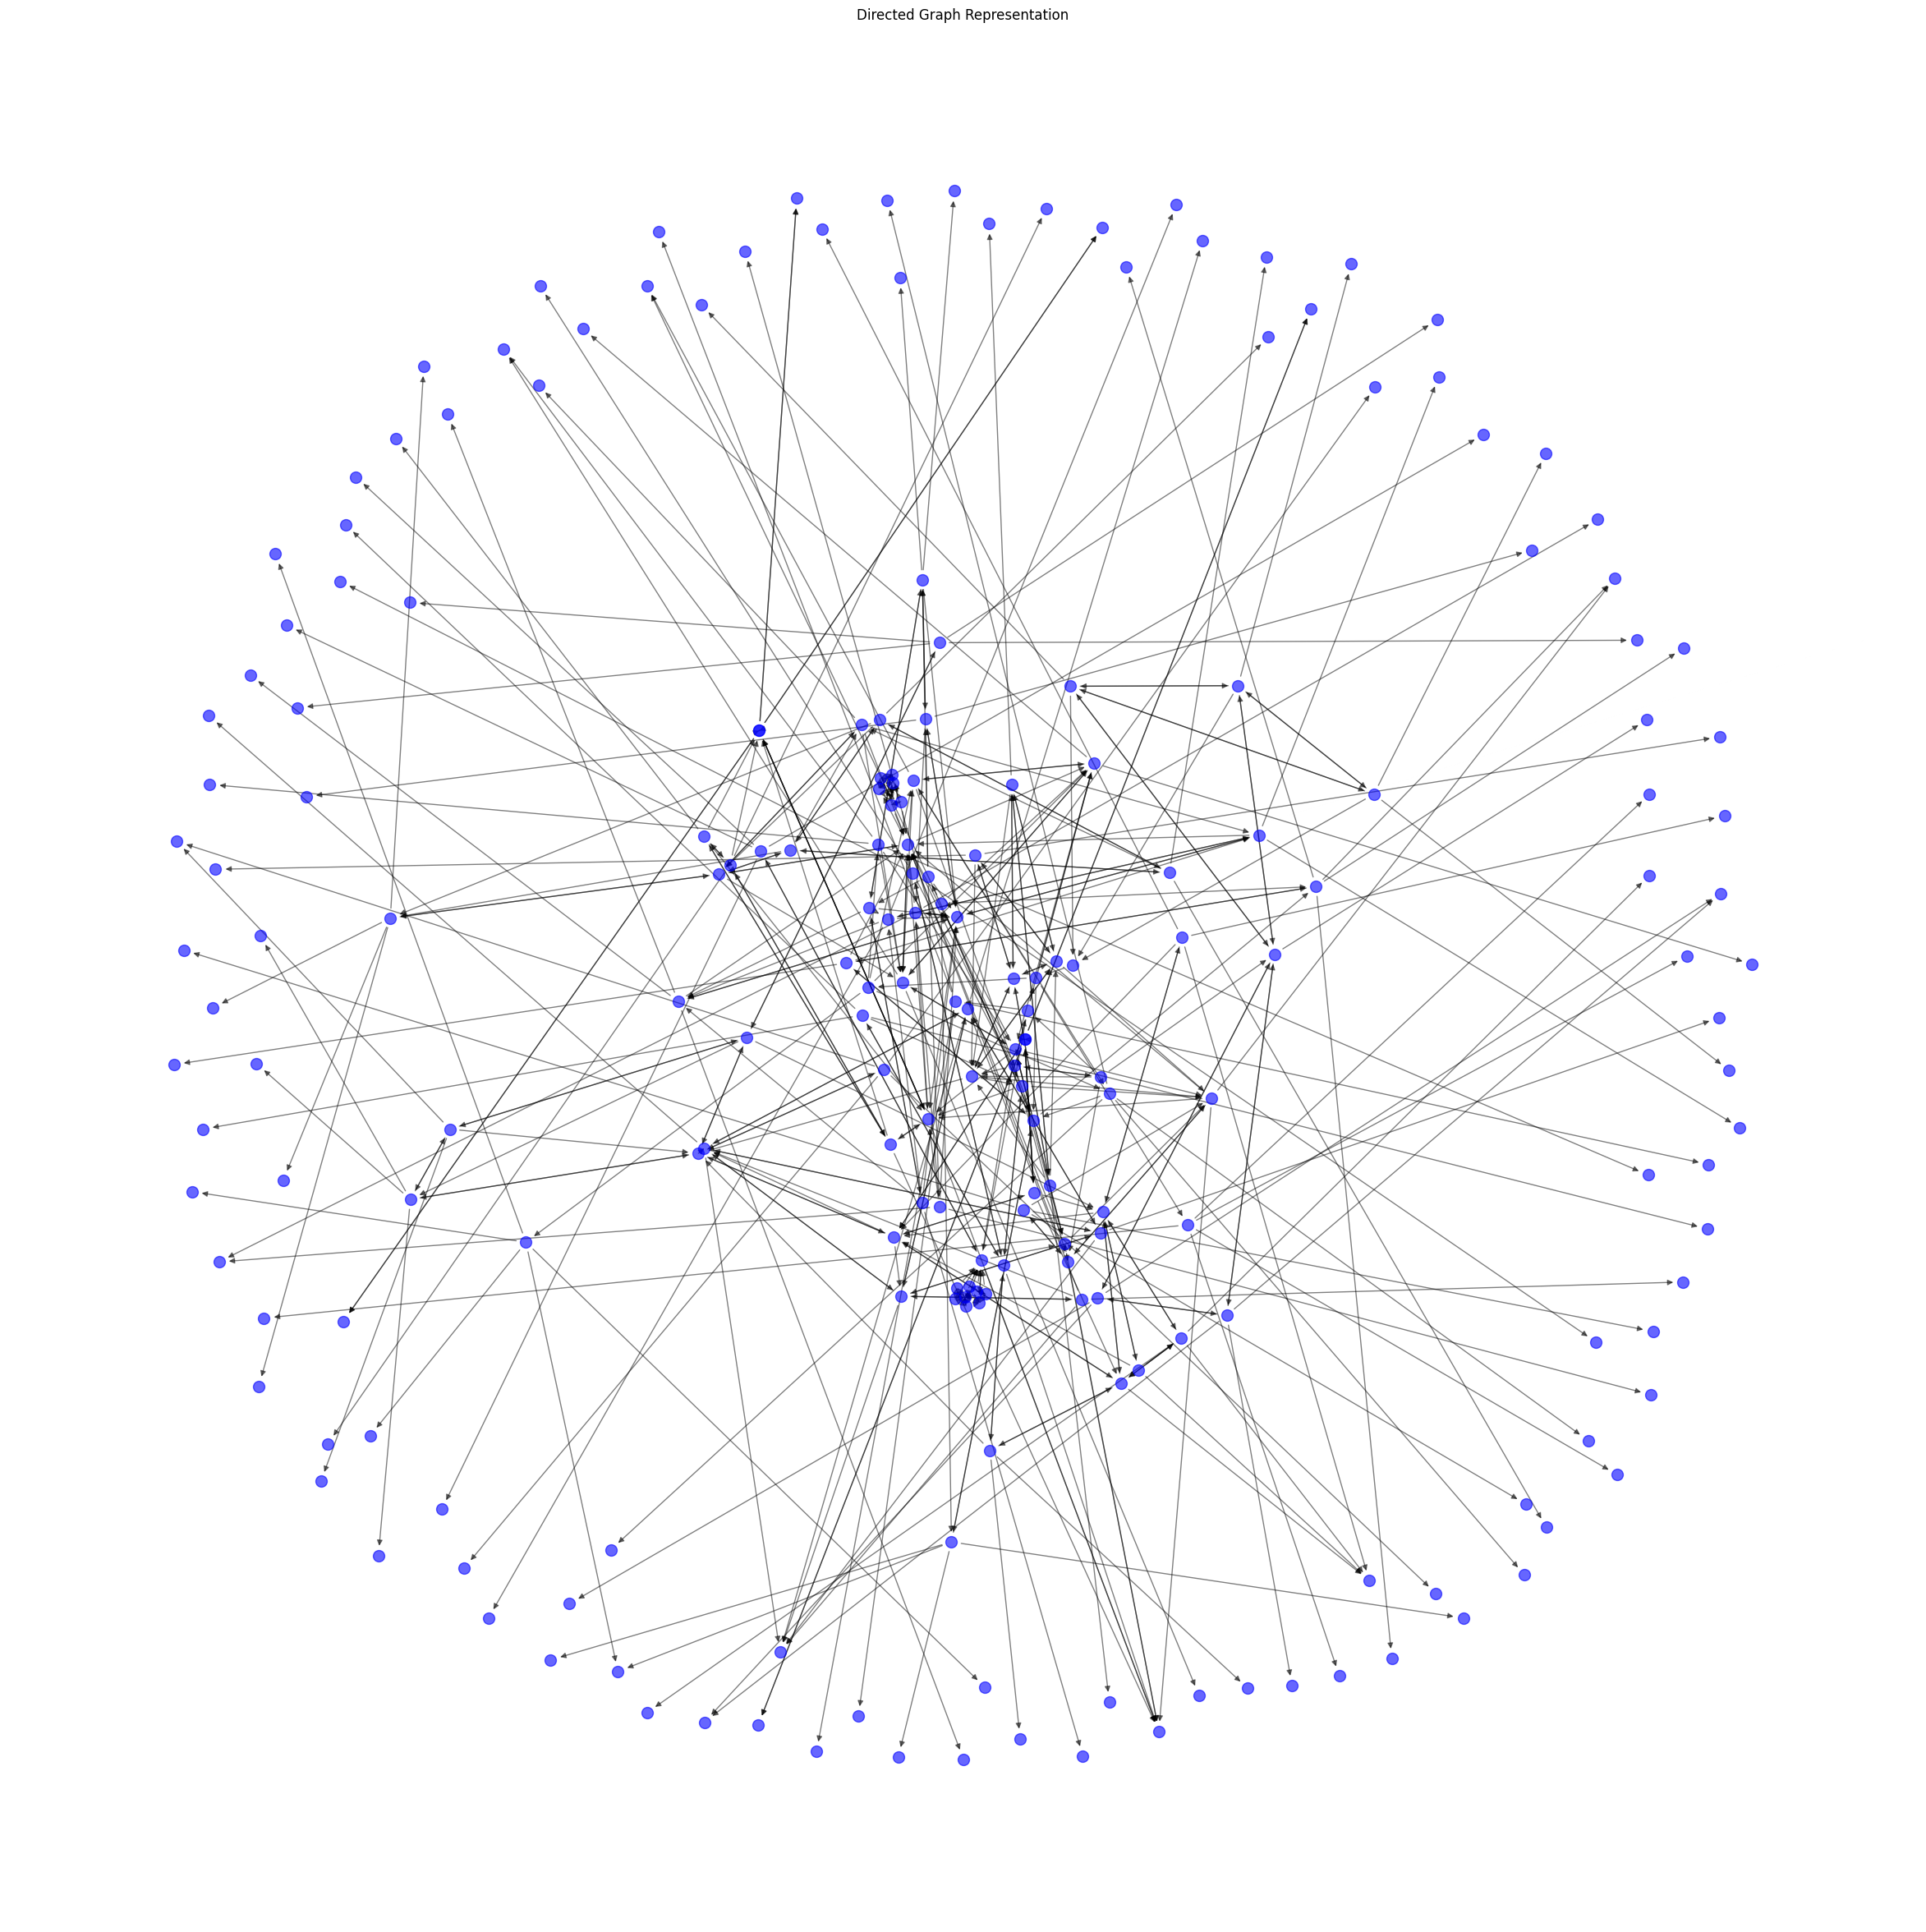

In [3]:
plt.figure(figsize=(30, 30))




pos = nx.spring_layout(G)

nx.draw_networkx_nodes(G, pos, node_size=100, node_color='blue', alpha=0.6)
nx.draw_networkx_edges(G, pos, width=1, alpha=0.5, arrowstyle='-|>', arrowsize=10)


plt.title('Directed Graph Representation')
plt.axis('off')
plt.show()

In [4]:
# Calculation of dataset statistics from : https://snap.stanford.edu/data/amazon0302.html


print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())


G_undirected = G.to_undirected()

# Find all weakly connected components, sorted by size
wccs = sorted(nx.connected_components(G_undirected), key=len, reverse=True)
sccs = sorted(nx.strongly_connected_components(G), key=len, reverse=True)

# Largest WCC
largest_wcc = wccs[0]
largest_scc = sccs[0]

# You can access the subgraph of the largest WCC like this
largest_wcc_subgraph = G.subgraph(largest_wcc)
largest_scc_subgraph = G.subgraph(largest_scc)

# Basic information about the largest WCC
print("Number of nodes in the largest WCC:", len(largest_wcc))
print("Number of edges in the largest WCC:", largest_wcc_subgraph.number_of_edges())
print("Number of nodes in the largest SCC:", len(largest_scc))
print("Number of edges in the largest SCC:", largest_scc_subgraph.number_of_edges())
print("Average Clustering Coeff:", nx.average_clustering(G))
print("Number of Triangles:", len(nx.triangles(G_undirected)))
print("Fraction of closed Triangles: ", nx.transitivity(G))
#print("Diameter (longest Shortest path):", nx.diameter(G_undirected))

Number of nodes: 217
Number of edges: 500
Number of nodes in the largest WCC: 217
Number of edges in the largest WCC: 500
Number of nodes in the largest SCC: 42
Number of edges in the largest SCC: 151
Average Clustering Coeff: 0.19310262935964354
Number of Triangles: 217
Fraction of closed Triangles:  0.29518072289156627


In [5]:
def clean_category_list(cat_list):
    cleaned_list = [item.split('[')[0].strip() for item in cat_list if '[' in item]
    return cleaned_list

In [6]:
fhr = open('amazon-meta.txt', 'r', encoding='utf-8', errors='ignore')

productList = []
count = 0
for line in fhr:
    
    line = line.strip()
    # a product block started
    if(line.startswith("Id")):
        Id = line[3:].strip()
    elif(line.startswith("ASIN")):
        ASIN = line[5:].strip()
    elif(line.startswith("group")):
        Group = line[6:].strip()
    elif(line.startswith("salesrank")):
        SalesRank = line[10:].strip()
    elif(line.startswith("similar")):
        Similar = line.strip().split()
        similarList=[]
        if(len(Similar)>2):
            for k in range(2,len(Similar),1):
                similarList.append(Similar[k])
    elif(line.startswith("categories")):
        ls = line.split()
        if(ls[1]!="0"):        
            Common_Categories = ' '.join((fhr.readline()).lower() for i in range(1))
            Common_Categories= Common_Categories.split("|")
            #print(Catagories)
        else:
            Common_Categories=""
    elif(line.startswith("reviews")):
        ls = line.split()
        TotalReviews = ls[2].strip()
        AvgRating = ls[7].strip()

    # a product block ended
    # write out fields to list
    elif (line==""):
        try:
            MetaData = []
            MetaData.append(Id)
            MetaData.append(ASIN)
            MetaData.append(Group)
            MetaData.append(SalesRank)
            MetaData.append(similarList)
            MetaData.append(Common_Categories)
            MetaData.append(TotalReviews)
            MetaData.append(AvgRating)
            productList.append(MetaData)
        except NameError:
            continue
fhr.close()

# # create books-specific list exclusively for books
# bookList = []
# count=0
# for product in productList:
#         if (product[2]=='Book'):
#             if(len(product[5])>3):
#                 Categories=product[5][3]
#                 Categories=Categories[0: Categories.index("["):]
#                 product[5]=Categories
#             bookList.append(product)
#             count+=1
#         if count == 200000:
#             break

df = pd.DataFrame(productList, columns = ['Id', 'ASIN',"Group",'SalesRank','Similar','Categories','TotalReviews','AvgRating',])
df['Categories'] = df['Categories'].apply(clean_category_list)
df['Id'] = df['Id'].astype(int)
df['SalesRank'] = df['SalesRank'].astype(int)
df['TotalReviews'] = df['TotalReviews'].astype(int)
df['AvgRating'] = df['AvgRating'].astype(float)
df

,Id,ASIN,Group,SalesRank,Similar,Categories,TotalReviews,AvgRating
0,1,0827229534,Book,396585,"[0804215715, 156101074X, 0687023955, 068707423...","[books, subjects, religion & spirituality, chr...",2,5.0
1,2,0738700797,Book,168596,"[0738700827, 1567184960, 1567182836, 073870052...","[books, subjects, religion & spirituality, ear...",12,4.5
2,3,0486287785,Book,1270652,[],"[books, subjects, home & garden, crafts & hobb...",1,5.0
3,4,0842328327,Book,631289,"[0842328130, 0830818138, 0842330313, 084232861...","[books, subjects, religion & spirituality, chr...",1,4.0
4,5,1577943082,Book,455160,"[157794349X, 0892749504, 1577941829, 089274956...","[books, subjects, religion & spirituality, chr...",0,0.0
...,...,...,...,...,...,...,...,...
548546,548547,B000059TOC,DVD,0,"[630366704X, B0002ERXB8, B0001932ZU, B0001VTPU...","[, dvd, genres, drama, general]",1,5.0
548547,548548,B00006JBIX,DVD,0,"[B0002HOE6C, B0002I84JO, B00004WZQN, B00069CQ8...","[, dvd, genres, art house & international, gen...",8,3.0
548548,548549,0879736836,Book,0,"[1931709920, 188187110X, 081890643X, 158051046...","[books, subjects, nonfiction, social sciences,...",1,4.0
548549,548550,B00008DDST,DVD,0,"[B00012FWNC, B0002UNQQI, B00069FKLO, B0000CNTH...","[, dvd, genres, music video & concerts, general]",3,5.0


### Finding communities with Girvan newman algo

In [7]:
# From : https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.centrality.girvan_newman.html

import itertools

k = 4
comp = nx.community.girvan_newman(G)
limited = itertools.takewhile(lambda c: len(c) <= k, comp)
for communities in limited:
    coms = ()
    coms = tuple(sorted(c) for c in communities)
    
for i in coms:
    print(i)
    print()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 57, 58, 59, 63, 64, 65, 66, 67, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 90, 97, 98, 99, 100, 101, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 121, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 156, 157, 158, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 175, 176, 177, 265, 266, 267, 268, 269, 270, 271, 272, 273, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 298, 307, 418, 419, 422, 423, 424, 425, 426, 430]

[15, 68, 69, 70, 71, 72, 102, 103, 104, 105, 106, 107, 178, 179, 420, 421]

[12, 260, 261, 262, 263, 264]

[18, 32, 33, 34, 35, 36, 51, 52, 53, 54, 55, 56, 60, 61, 62, 84, 91, 92, 93, 94, 95, 96, 148, 149, 150, 151, 152, 153, 154, 155, 159, 160, 161, 162, 163, 174, 274, 275, 276, 277, 278, 295, 296, 297, 427, 428, 429]



In [8]:
from collections import Counter

count = 0
groups = []
for i in coms:
    group_counts = Counter()
    for j in i:
        if str(j) in df['Id'].values:
            group_value = df.loc[df['Id'] == str(j), 'Group'].iloc[0]
        else:
            group_value = "No info"
        group_counts.update([group_value])
        
    if group_counts:
        most_common_group = group_counts.most_common(1)[0]
        print(f"The most frequent group for {count} is {most_common_group}")
        groups.append(most_common_group)
    count += 1

The most frequent group for 0 is ('No info', 148)
The most frequent group for 1 is ('No info', 16)
The most frequent group for 2 is ('No info', 6)
The most frequent group for 3 is ('No info', 47)


C:\Users\email\AppData\Local\Temp\ipykernel_19292\3850163992.py:8: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if str(j) in df['Id'].values:


In [19]:
def analyze_community(group:list[str], common_categories_threshold):
    group_df = df[df['Id'].isin(group)]

    most_common_group = group_df['Group'].value_counts().idxmax()

    most_common_group_percent = round(len(group_df[group_df['Group'] == most_common_group]) / len(group_df),2)

    salesrank_cv = round(group_df['SalesRank'].std() / group_df['SalesRank'].mean(),2)

    totalreviews_cv = round(group_df['TotalReviews'].std() / group_df['TotalReviews'].mean(),2)

    avgrating_cv = round(group_df['AvgRating'].std() / group_df['AvgRating'].mean(),2)

    Common_Categories = {}
    for index, row in group_df.iterrows():
        cats = list(row['Categories'])
        for c in cats:
            if c in Common_Categories:
                Common_Categories[c] += 1
            else:
                Common_Categories[c] = 0
    
    for key, value in list(Common_Categories.items()):
        if value / len(group_df) <= common_categories_threshold:
            del Common_Categories[key]
        else:
            Common_Categories[key] = round(group_df['Categories'].apply(lambda x: key in list(x)).sum() / len(group_df),2)
    
    return {"Most Common Group": most_common_group,
            "Most Common Group Percent": most_common_group_percent,
            "Sales Rank Coefficient of Variation": salesrank_cv,
            "Total Reviews Coefficient of Variation": totalreviews_cv,
            "Average Rating Coefficient of Variation": avgrating_cv,
            "Common Categories": Common_Categories}

temp = [analyze_community(c, 0.75) for c in coms]
community_analysis = pd.DataFrame(temp, columns=['Most Common Group', 
                                           'Most Common Group Percent', 
                                           'Sales Rank Coefficient of Variation', 
                                           'Total Reviews Coefficient of Variation',
                                           'Average Rating Coefficient of Variation',
                                           'Common Categories'])
community_analysis

,Most Common Group,Most Common Group Percent,Sales Rank Standard Deviation,Total Reviews Standard Deviation,Average Rating Standard Deviation,Common Categories
0,Book,0.84,595364.665026,20.319845,1.861653,"{'books': 0.82, 'subjects': 0.81}"
1,Book,0.88,627634.640872,3.473711,2.130874,"{'books': 0.88, 'subjects': 0.88}"
2,Book,1.00,601284.615270,8.710147,1.816590,"{'books': 1.0, 'subjects': 1.0}"
3,Book,0.85,496932.410798,443.965758,2.039900,"{'books': 0.83, 'subjects': 0.83}"
